In [1]:
#   from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_classif
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import math
import plotly.express as px
%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
 cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/Users/dam157/Downloads/Machine Learning/Project_5 - Sendy Logistics


In [4]:
#riders = pd.read_csv('Riders.csv')
train_raw = pd.read_csv( 'Train.csv')
test = pd.read_csv( 'Test.csv')

In [5]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [6]:
# # Convert time columns to datetime
# time_columns = [
#     "Confirmation - Time",
#     "Arrival at Pickup - Time",
#     "Pickup - Time",
#     "Arrival at Destination - Time"
# ]

# for col in time_columns:
#     train_raw[col] = pd.to_datetime(train_raw[col], format='%I:%M:%S %p').dt.time

# # Function to convert time to seconds since midnight
# def time_to_seconds(t):
#     return t.hour * 3600 + t.minute * 60 + t.second

# # Apply conversion
# for col in time_columns:
#     train_raw[f"{col}(Seconds since midnight)"] = train_raw[col].apply(time_to_seconds)



# train_raw['Placement - Time'] = pd.to_datetime(train_raw['Placement - Time'])

# # Extract the hour from the 'Placement - Time'
# train_raw['Placement_Hour'] = train_raw['Placement - Time'].dt.hour


# train_raw[col] = pd.to_datetime(train_raw[col], format='%H:%M:%S').dt.time

# # Drop original time columns
# train_raw.drop(columns=time_columns, inplace=True)

In [7]:
# test.head(10)

In [8]:
# Convert time columns to datetime
time_columns = [
    "Confirmation - Time",
    "Arrival at Pickup - Time",
    "Pickup - Time"
]

for col in time_columns:
    test[col] = pd.to_datetime(test[col], format='%I:%M:%S %p').dt.time

# Function to convert time to seconds since midnight
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

# Apply conversion
for col in time_columns:
    test[f"{col}(Seconds since midnight)"] = test[col].apply(time_to_seconds)



test['Placement - Time'] = pd.to_datetime(test['Placement - Time'])

# Extract the hour from the 'Placement - Time'
test['Placement_Hour'] = test['Placement - Time'].dt.hour


test[col] = pd.to_datetime(test[col], format='%H:%M:%S').dt.time

# Drop original time columns
test.drop(columns=time_columns, inplace=True)

/var/folders/gn/clhq9k9140jfd9jjcjjjpqvh0000gn/T/ipykernel_57837/3172539974.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Placement - Time'] = pd.to_datetime(test['Placement - Time'])


In [9]:
train_raw.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [10]:
px.scatter_mapbox(train_raw,
                  lat='Pickup Lat',
                  lon='Pickup Long',
                  color='Time from Pickup to Arrival',
                  color_continuous_scale=px.colors.cyclical.IceFire,
                  size='Distance (KM)',
                  size_max=15,
                  zoom=9.3,
                  mapbox_style='open-street-map',
                  title='Pickup Location')

In [11]:
px.scatter_mapbox(train_raw,
                  lat='Destination Lat',
                  lon='Destination Long',
                  color='Time from Pickup to Arrival',
                  size='Distance (KM)',
                  color_continuous_scale=px.colors.cyclical.IceFire,
                  size_max=15,
                  zoom=9.3,
                  mapbox_style='open-street-map',
                  title='Destination Location')

In [12]:
# # Calculate the average temperature for each hour
# hourly_avg_temp = test.groupby('Placement_Hour')['Temperature'].mean()

# # Function to fill NaN values with the average temperature of the corresponding hour
# def fill_temperature(row):
#     if pd.isnull(row['Temperature']):
#         return hourly_avg_temp[row['Placement_Hour']]
#     return row['Temperature']

# # Apply the function to fill NaN values
# test['Temperature'] = test.apply(fill_temperature, axis=1)

# # Drop the auxiliary 'Hour' column
# test.drop('Placement_Hour', axis=1, inplace=True)
# test

# #Round it off to one decimal places
# test['Temperature'] = test['Temperature'].round(1)

In [13]:
# # Calculate the average temperature for each hour
# hourly_avg_temp = train_raw.groupby('Placement_Hour')['Temperature'].mean()

# # Function to fill NaN values with the average temperature of the corresponding hour
# def fill_temperature(row):
#     if pd.isnull(row['Temperature']):
#         return hourly_avg_temp[row['Placement_Hour']]
#     return row['Temperature']

# # Apply the function to fill NaN values
# train_raw['Temperature'] = train_raw.apply(fill_temperature, axis=1)

# # Drop the auxiliary 'Hour' column
# train_raw.drop('Placement_Hour', axis=1, inplace=True)
# train_raw

# #Round it off to one decimal places
# train_raw['Temperature'] = train_raw['Temperature'].round(1)

In [14]:
# train_raw.drop('Precipitation in millimeters', axis=1, inplace=True)
# test.drop('Precipitation in millimeters', axis=1, inplace=True)

In [15]:
# Set the style of the plot for better aesthetics
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_raw['Arrival at Destination - Time'])

# Set the title and labels
plt.title('Arrival at Destination - Time(Seconds since midnight)')
plt.xlabel('Time from pickup to arrival')

# Show the plot
plt.show()

TypeError: Horizontal orientation requires numeric `x` variable.

<Figure size 1000x600 with 0 Axes>

In [ ]:
train_raw.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [ ]:
# train_raw = train_raw[train_raw['Arrival at Destination - Time(Seconds since midnight)'] < 78000]
# train_raw = train_raw[train_raw['Arrival at Destination - Time(Seconds since midnight)'] > 25000]

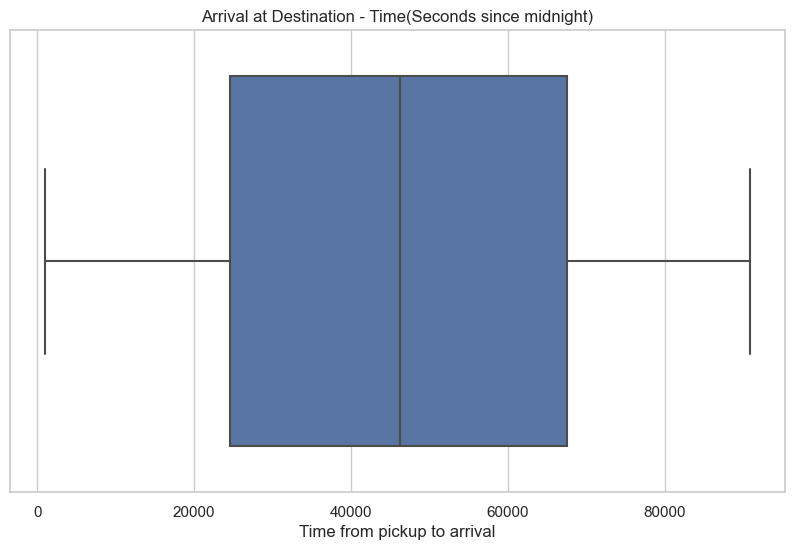

In [ ]:
# Set the style of the plot for better aesthetics
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_raw['Arrival at Destination - Time'])

# Set the title and labels
plt.title('Arrival at Destination - Time(Seconds since midnight)')
plt.xlabel('Time from pickup to arrival')

# Show the plot
plt.show()

In [ ]:
train = train_raw.drop( columns = ['Placement - Time'])

In [ ]:
# from scipy import stats


# #Calculate the z-scores
# z_scores = stats.zscore(train)

# #Set a threshold for identifying outliers
# threshold = 3

# #Identify outliers
# outliers = np.where(np.abs(z_scores) > threshold)

# print("Z-scores:", z_scores)
# print("Outliers:", outliers[0])

In [ ]:
train_raw.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [ ]:
# Define features and target
X = train_raw.drop(columns=["Order No", "User Id", "Rider Id", "Arrival at Destination - Time",
                            'Time from Pickup to Arrival','Destination Long','Destination Lat','Pickup Long','Pickup Lat',
                            'Arrival at Destination - Weekday (Mo = 1)','Arrival at Destination - Day of Month',
                            'Arrival at Pickup - Day of Month','Arrival at Pickup - Weekday (Mo = 1)','Confirmation - Weekday (Mo = 1)',
                            'Confirmation - Day of Month','Placement - Day of Month','Placement - Weekday (Mo = 1)', 'Placement - Time',])
y = train_raw["Arrival at Destination - Time"]


#X = test.drop(columns=["Order No", "User Id", "Rider Id"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X

Vehicle Type  Platform Type Personal or Business  Confirmation - Time  \
0             Bike              2             Personal                53300   
1             Bike              3             Business                15375   
2             Bike              1             Business                38303   
3             Bike              2             Personal                71091   
4              Car              4             Personal                67650   
...            ...            ...                  ...                  ...   
99995         Bike              4             Personal                36520   
99996         Bike              1             Personal                16046   
99997          Car              1             Personal                18104   
99998          Car              3             Personal                 9171   
99999         Bike              3             Business                50891   

       Arrival at Pickup - Time  Pickup - Day of Month  \
0                         53645                      7   
1                         15823                     24   
2                         38719                     12   
3                         71419                     23   
4                         67970                     15   
...                         ...                    ...   
99995                     36823                     15   
99996                     16568                     10   
99997                     18592                     12   
99998                      9761                      7   
99999                     51329                     29   

       Pickup - Weekday (Mo = 1)  Pickup - Time  Distance (KM)  Temperature  \
0                              2          53925       8.294172    26.144385   
1                              5          16036       8.921319    30.676841   
2                              5          38889      12.853441    24.268248   
3                              4          71509      13.058255    19.446127   
4                              5          68153       6.373857    27.659480   
...                          ...            ...            ...          ...   
99995                          7          37110       7.850182    27.525301   
99996                          2          16737       8.772510    16.402298   
99997                          3          18851       6.131684    28.891455   
99998                          7          10009      12.483375    34.096618   
99999                          7          51582      10.097986    17.821092   

       Precipitation in millimeters  
0                          0.236505  
1                          0.501517  
2                          0.912016  
3                          0.267052  
4                          1.455240  
...                             ...  
99995                      0.238917  
99996                      0.216714  
99997                      0.329902  
99998                      1.204742  
99999                      0.909627  

[100000 rows x 11 columns]

In [ ]:
train_raw.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [ ]:
# Preprocessing pipelines for numerical and categorical data
numerical_features = ['Pickup - Day of Month',
                      'Pickup - Weekday (Mo = 1)','Distance (KM)',
                      'Temperature']

categorical_features = ["Vehicle Type", "Platform Type", "Personal or Business"]

# Verify that all columns exist in X_train
missing_numerical = [col for col in numerical_features if col not in train_raw.columns]
missing_categorical = [col for col in categorical_features if col not in train_raw.columns]

if missing_numerical or missing_categorical:
    print("Missing numerical columns:", missing_numerical)
    print("Missing categorical columns:", missing_categorical)
    raise ValueError("Some columns are missing from the dataframe")

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = RandomForestRegressor(n_estimators=500, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Train the model
pipeline.fit(train_raw,y)

In [ ]:
test.head()

Order No       User Id Vehicle Type  Platform Type  \
0  Order_No_19248  User_Id_3355         Bike              3   
1  Order_No_12736  User_Id_3647         Bike              3   
2    Order_No_768  User_Id_2154         Bike              3   
3  Order_No_15332  User_Id_2910         Bike              3   
4  Order_No_21373  User_Id_1205         Bike              3   

  Personal or Business  Placement - Day of Month  \
0             Business                        27   
1             Business                        17   
2             Business                        27   
3             Business                        17   
4             Business                        11   

   Placement - Weekday (Mo = 1)    Placement - Time  \
0                             3 2024-06-12 16:44:10   
1                             5 2024-06-12 12:57:35   
2                             4 2024-06-12 11:08:14   
3                             1 2024-06-12 13:51:35   
4                             2 2024-06-12 11:30:28   

   Confirmation - Day of Month  Confirmation - Weekday (Mo = 1)  \
0                           27                                3   
1                           17                                5   
2                           27                                4   
3                           17                                1   
4                           11                                2   

   Arrival at Pickup - Day of Month  Arrival at Pickup - Weekday (Mo = 1)  \
0                                27                                     3   
1                                17                                     5   
2                                27                                     4   
3                                17                                     1   
4                                11                                     2   

   Pickup - Day of Month  Pickup - Weekday (Mo = 1)  Distance (KM)  \
0                     27                          3              8   
1                     17                          5              5   
2                     27                          4              5   
3                     17                          1              5   
4                     11                          2              6   

   Temperature  Precipitation in millimeters  Pickup Lat  Pickup Long  \
0          NaN                           NaN   -1.333275    36.870815   
1          NaN                           NaN   -1.272639    36.794723   
2         22.8                           NaN   -1.290894    36.822971   
3         24.5                           NaN   -1.290503    36.809646   
4         24.4                           NaN   -1.281081    36.814423   

   Destination Lat  Destination Long      Rider Id  \
0        -1.305249         36.822390  Rider_Id_192   
1        -1.277007         36.823907  Rider_Id_868   
2        -1.276574         36.851365   Rider_Id_26   
3        -1.303382         36.790658  Rider_Id_685   
4        -1.266467         36.792161  Rider_Id_858   

   Confirmation - Time(Seconds since midnight)  \
0                                        60269   
1                                        46757   
2                                        41105   
3                                        50007   
4                                        41685   

   Arrival at Pickup - Time(Seconds since midnight)  \
0                                             60784   
1                                             48027   
2                                             41600   
3                                             50561   
4                                             42439   

   Pickup - Time(Seconds since midnight)  Placement_Hour  
0                                  61607              16  
1                                  48337              12  
2                                  43074              11  
3                                  51412              13  
4       

In [ ]:
# Make predictions
y_pred = pipeline.predict(X_test)

#Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Root Mean Squared Error: 9359.197546580006
R^2 Score: 0.8576968550234181


In [ ]:
predictions = pipeline.predict(test)
df_submission = pd.DataFrame()
df_submission["Order_No"] = test['Order No']
df_submission["Arrival at Destination Time"] = predictions

df_submission['Time from Pickup to Arrival'] = predictions - test['Pickup - Time(Seconds since midnight)']
df_submission.to_csv("predictions.csv",index=False)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:

# # Function to convert seconds since midnight to HH:MM:SS format
# def seconds_to_time(seconds):
#     hours = seconds // 3600
#     minutes = (seconds % 3600) // 60
#     seconds = seconds % 60
#     return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

# # Function to convert time in 24-hour format to seconds since midnight
# def time_to_seconds_24h(time_str):
#     parts = time_str.split(':')
#     hours = int(parts[0])
#     minutes = int(parts[1])
#     seconds = int(parts[2])
#     return hours * 3600 + minutes * 60 + seconds

# # Get user input for required features
# user_input = {
#     "Vehicle Type": input("Enter Vehicle Type (e.g., Car, Bike): "),
#     "Platform Type": int(input("Enter Platform Type (e.g., 1, 2): ")),
#     "Personal or Business": input("Enter Personal or Business: "),
#     "Pickup - Day of Month": int(input("Enter Pickup - Day of Month: ")),
#     "Pickup - Weekday (Mo = 1)": int(input("Enter Pickup - Weekday (Mo = 1): ")),
#     "Pickup - Time": input("Enter Pickup - Time (HH:MM:SS 24-hour format): "),
#     "Distance (KM)": float(input("Enter Distance (KM): ")),
#     "Temperature": float(input("Enter Temperature: "))
# }

# # Convert time inputs to seconds since midnight using 24-hour format
# user_input["Pickup - Time(Seconds since midnight)"] = time_to_seconds_24h(user_input["Pickup - Time"])

# # Create a DataFrame for the user input
# user_input_df = pd.DataFrame([user_input])

# # Drop original time columns
# user_input_df.drop(columns=["Pickup - Time"], inplace=True)

# # Make predictions
# new_prediction = pipeline.predict(user_input_df)

# # Convert predicted time in seconds since midnight to HH:MM:SS format
# predicted_time = seconds_to_time(new_prediction[0])

# # Display the predicted arrival time
# print("Predicted Arrival at Destination Time (24-hour format):", predicted_time)

In [ ]:
# # Preprocessing pipelines for numerical and categorical data
# numerical_features = ['Pickup - Day of Month',
#                       'Pickup - Weekday (Mo = 1)','Distance (KM)',
#                       'Temperature','Pickup - Time(Seconds since midnight)']
# categorical_features = ["Vehicle Type", "Platform Type", "Personal or Business"]

# # Verify that all columns exist in train_raw
# missing_numerical = [col for col in numerical_features if col not in train_raw.columns]
# missing_categorical = [col for col in categorical_features if col not in train_raw.columns]

# if missing_numerical or missing_categorical:
#     print("Missing numerical columns:", missing_numerical)
#     print("Missing categorical columns:", missing_categorical)
#     raise ValueError("Some columns are missing from the dataframe")

# numerical_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# # Define the model
# model = LinearRegression()

# # Create the pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# # Perform cross-validation
# cv_scores = cross_val_score(pipeline, train_raw, y, cv=10, scoring='neg_mean_squared_error')

# # Convert negative MSE to positive and compute the RMSE for each fold
# rmse_scores = np.sqrt(-cv_scores)

# print(f"Cross-Validation RMSE Scores: {rmse_scores}")
# print(f"Mean RMSE: {rmse_scores.mean()}")


Cross-Validation RMSE Scores: [826.01847444 841.10360939 816.91182374 816.77942227 800.06321206
 807.94739899 768.70695024 790.83814028 769.51491073 789.82495991]
Mean RMSE: 802.7708902052431


In [ ]:
# from sklearn.linear_model import Ridge

# # Preprocessing pipelines for numerical and categorical data
# numerical_features = ['Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Distance (KM)', 'Temperature', 'Pickup - Time(Seconds since midnight)']
# categorical_features = ["Vehicle Type", "Platform Type", "Personal or Business"]

# # Verify that all columns exist in train_raw
# missing_numerical = [col for col in numerical_features if col not in train_raw.columns]
# missing_categorical = [col for col in categorical_features if col not in train_raw.columns]

# if missing_numerical or missing_categorical:
#     print("Missing numerical columns:", missing_numerical)
#     print("Missing categorical columns:", missing_categorical)
#     raise ValueError("Some columns are missing from the dataframe")

# numerical_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# # Define the model
# model =  RandomForestRegressor(n_estimators= 100, random_state=42) # You can adjust the alpha parameter as needed

# # Create the pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# # Perform cross-validation
# cv_scores = cross_val_score(pipeline, train_raw, y, cv=10, scoring='neg_mean_squared_error')

# # Convert negative MSE to positive and compute the RMSE for each fold
# rmse_scores = np.sqrt(-cv_scores)

# print(f"Cross-Validation RMSE Scores: {rmse_scores}")
# print(f"Mean RMSE: {rmse_scores.mean()}")

Cross-Validation RMSE Scores: [868.25498201 881.25731525 857.78738207 880.39411926 846.19695434
 861.59684705 835.65323069 843.35057678 832.75197723 854.26555945]
Mean RMSE: 856.1508944136191


In [ ]:
import pickle

# Assuming 'model' is your trained RandomForestRegressor model
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(model, file)